In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import dask.dataframe as dd
from geopy.distance import geodesic
import string

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**🕵️‍♂️ Credit Card Fraud Detection**

Credit card fraud is a growing concern in today's increasingly digital financial landscape, leading to significant financial losses for both consumers and financial institutions.

This project focuses on analyzing a real-world dataset of credit card transactions in the US to uncover patterns indicative of fraudulent activity. Through:

- 📊 **Exploratory Data Analysis**
- 🛠️ **Feature Engineering**
- 🤖 **Machine Learning Modeling**

we aim to build a robust fraud detection system capable of distinguishing between legitimate and suspicious transactions.

> 💡 **Goal:** Enhance early fraud detection and reduce the impact of fraudulent activity within financial systems.

**🧹 Data Preparation for Fraud Detection**

Preparation is required before diving into the modeling

- 📦 **Sample a large dataset and verify the 300K rows sample and the datase distributions are the same.**
- 🧼 **Handling missing or inconsistent values**
- 🏷️ **Converting date and time fields into usable formats**


In [2]:
ddf = dd.read_csv('../csv/credit_card_fraud.csv', dtype={'trans_time': 'object'})
# Combine 'trans_date' and 'trans_time' into a single datetime column
ddf['Datetime'] = dd.to_datetime(ddf['trans_date'] + ' ' + ddf['trans_time'], format='%Y-%m-%d %H:%M:%S')

In [3]:

def compute_monthly_fraud_percentage(df):    
    # Extract month period
    df['Month'] = df['Datetime'].dt.to_period('M')

    # Group by month
    monthly_total = df.groupby('Month').size().rename('Total')
    monthly_fraud = df[df['is_fraud'] == 1].groupby('Month').size().rename('Fraud')

    # Merge and compute fraud percentage
    monthly_stats = dd.concat([monthly_total, monthly_fraud], axis=1)
    monthly_stats['Fraud'] = monthly_stats['Fraud'].fillna(0)
    monthly_stats['Fraud_Percentage'] = (monthly_stats['Fraud'] / monthly_stats['Total']) * 100

    # Execute the computation and sort by Month
    monthly_stats = monthly_stats.compute().sort_index()
    
    return monthly_stats

In [4]:
monthly_stats_full = compute_monthly_fraud_percentage(ddf)
print('Monthly stats full:')
print(monthly_stats_full)

Monthly stats full:
           Total  Fraud  Fraud_Percentage
Month                                    
2019-01   970166   8248          0.850164
2019-02   894861   7207          0.805376
2019-03  1361254   8086          0.594011
2019-04  1250772   7773          0.621456
2019-05  1399709   8325          0.594766
2019-06  1638624   8196          0.500176
2019-07  1601861   7852          0.490180
2019-08  1671809   8296          0.496229
2019-09  1292073   8311          0.643230
2019-10  1291812   8091          0.626330
2019-11  1364656   7943          0.582051
2019-12  2606359   7873          0.302069
2020-01   982745   8031          0.817201
2020-02   956016   7512          0.785761
2020-03  1305878   7974          0.610624
2020-04  1258255   7743          0.615376
2020-05  1448073   8169          0.564129
2020-06  1558950   7642          0.490202
2020-07  1635879   7737          0.472957
2020-08  1669362   8427          0.504804
2020-09  1261903   8461          0.670495
2020-10  13367

In [5]:
# Sample the data
tot_rows = ddf.shape[0].compute()
print(f"Total number of rows in the dataset: {tot_rows}")
frac = 300_000 / tot_rows

print(f"Fraction to sample: {frac}")

ddf_sample = ddf.sample(frac=frac, random_state=42)

monthly_stats_sample = compute_monthly_fraud_percentage(ddf_sample)
print('Monthly stats sample:')
print(monthly_stats_sample)

Total number of rows in the dataset: 34636378
Fraction to sample: 0.008661413730962285
Monthly stats sample:
         Total  Fraud  Fraud_Percentage
Month                                  
2019-01   8435     67          0.794309
2019-02   7668     60          0.782473
2019-03  11917     75          0.629353
2019-04  10585     80          0.755786
2019-05  12005     82          0.683049
2019-06  14225     59          0.414763
2019-07  14029     76          0.541735
2019-08  14271     71          0.497512
2019-09  11370     83          0.729991
2019-10  11348     64          0.563976
2019-11  11737     66          0.562324
2019-12  22544     68          0.301632
2020-01   8495     54          0.635668
2020-02   8288     59          0.711873
2020-03  11301     79          0.699053
2020-04  10842     68          0.627191
2020-05  12634     79          0.625297
2020-06  13427     76          0.566024
2020-07  14201     67          0.471798
2020-08  14419     77          0.534018
2020-09  10

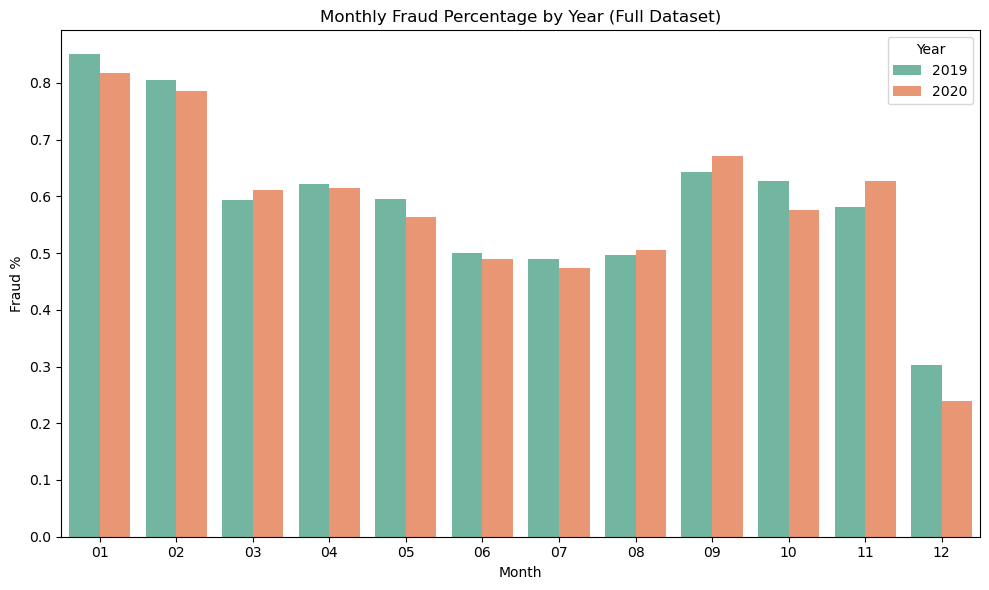

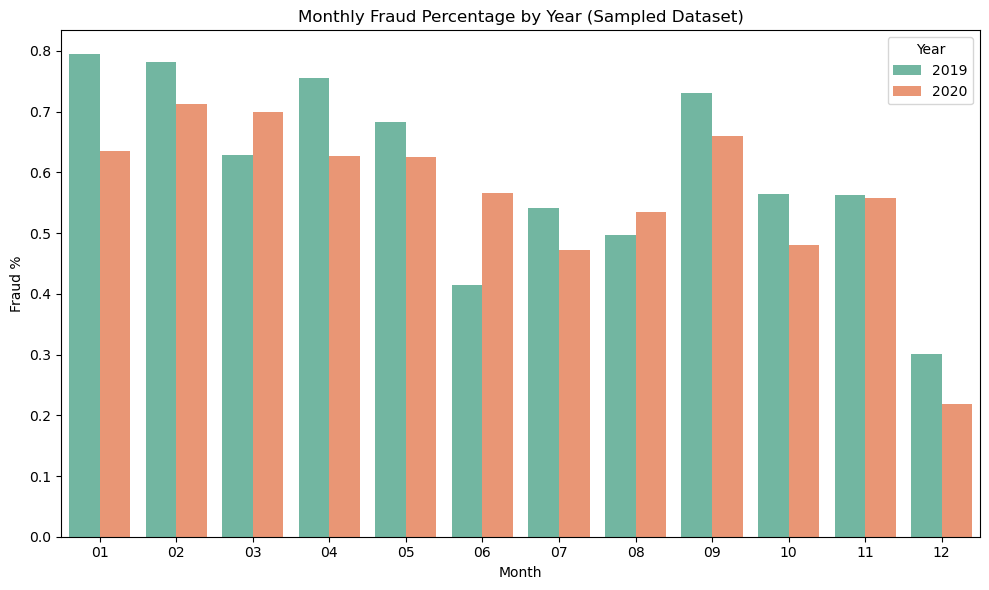

In [6]:
def plot_monthly_fraud_percentage(mon_stats, title='Monthly Fraud Percentage by Year'):
    # Reset index to access 'Month' as a column
    mon_stats = mon_stats.reset_index()

    # Split month into year and month components
    mon_stats['Year'] = mon_stats['Month'].astype(str).str[:4]
    mon_stats['MonthName'] = mon_stats['Month'].astype(str).str[5:7]  # e.g., '01', '02', etc.

    # Combine for sort and label
    mon_stats['Month_Label'] = mon_stats['MonthName']  # Will be x-axis (e.g., Jan, Feb...)
    mon_stats['Year'] = mon_stats['Year'].astype(str)

    # Sort by month name and year to make bars aligned (e.g., all Jan, all Feb)
    mon_stats = mon_stats.sort_values(by=['MonthName', 'Year'])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=mon_stats,
        x='Month_Label',
        y='Fraud_Percentage',
        hue='Year',
        palette='Set2'
    )
    plt.title(title)
    plt.ylabel('Fraud %')
    plt.xlabel('Month')
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()

plot_monthly_fraud_percentage(monthly_stats_full, title='Monthly Fraud Percentage by Year (Full Dataset)')
plot_monthly_fraud_percentage(monthly_stats_sample, title='Monthly Fraud Percentage by Year (Sampled Dataset)')


**🧾 Visual Comparison Conclusion (2020)**

A visual inspection comparing the full 2020 dataset and its sampled subset reveals that their distributions appear **highly similar across key variables**. Whether evaluating categorical frequencies or continuous value patterns, the sample closely mirrors the shape and spread of the full data. 

📌 This visual consistency further supports the statistical findings, suggesting that the 2020 sample is a **representative and unbiased reflection** of the full 2020 data.

📌 Next step, proceed to Chi-Square Test.

In [ ]:
ddf_2020 = ddf[ddf['Datetime'].dt.year == 2020]
ddf_sample_2020 = ddf_sample[ddf_sample['Datetime'].dt.year == 2020]

In [ ]:
from scipy.stats import chi2_contingency


# Chi-Square Test for 'is_fraud' column in 2020 subset
full_counts_2020 = ddf_2020['is_fraud'].value_counts()
sample_counts_2020 = ddf_sample_2020['is_fraud'].value_counts()

# Align and fill missing
comparison_2020 = pd.DataFrame({
    'full': full_counts_2020,
    'sample': sample_counts_2020
}).fillna(0)

# Run chi-square test
chi2_2020, p_chi2_2020, dof_2020, expected_2020 = chi2_contingency([comparison_2020['full'], comparison_2020['sample']])

# Return test results
result = {
    'Chi-Square Test for 2020': {
        'chi2_statistic': chi2_2020,
        'p_value': p_chi2_2020,
        'degrees_of_freedom': dof_2020
    }
}

print(result)

{'Chi-Square Test for 2020': {'chi2_statistic': 0.1993745447768406, 'p_value': 0.6552261697675091, 'degrees_of_freedom': 1}}


**📊 Chi-Square Test Conclusion**

We conducted a Chi-Square test to assess whether the distribution in our 300K rows sample differs significantly from the expected distribution.

- **Chi² Statistic**: `0.199`
- **p-value**: `0.655`
- **Degrees of Freedom**: `1`

✅ Since the p-value is **much greater than 0.05**, we **fail to reject the null hypothesis**. This suggests that the observed distribution is **statistically consistent** with the expected distribution.

> The sample distribution can be considered representative of the population for the tested variable.

> Proceed to preparation and work on the 300K rows 2020 sample.

In [ ]:
total_rows = ddf_2020.shape[0].compute()

frac = 300_000 / total_rows

ddf_sample_300K = ddf_2020.sample(frac=frac, random_state=42)

ddf_sample_300K.to_csv('sample_300k_2020.csv', single_file=True, index=False)

OSError: [Errno 22] Invalid argument: 'd:/pyProjects/DS18/ds18-ml-proj2/Credit_Card_Fraud/sample_300k_*.csv'

In [12]:
ddf_sample_300K.to_csv('sample_300k_2020.csv', single_file=True, index=False)

['d:\\pyProjects\\DS18\\ds18-ml-proj2\\Credit_Card_Fraud\\sample_300k_2020.csv']

In [3]:
df_prep = pd.read_csv('sample_300k_2020.csv')
df_prep.shape

(299996, 29)

In [5]:
df_prep.head()

,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,...,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,Datetime,Month
0,75649,241-50-6273,30171817317434,Julia,Ellis,F,69605 Matthew Trail,Brooklyn,NY,11205,...,16:23:32,1608461612,travel,5.52,0,fraud_Veum-Koelpin,40.450480,-73.896497,2020-12-20 16:23:32,2020-12
1,96984,543-56-5697,371482247799225,Michelle,Alexander,F,703 Barnes Drives,Columbia,SC,29229,...,15:12:30,1597398150,home,35.08,0,fraud_Reilly LLC,34.571573,-80.190513,2020-08-14 15:12:30,2020-08
2,64296,022-67-8359,4359119800352988,Phyllis,Bennett,F,7954 Richards Rapid,Saint George,UT,84790,...,13:03:15,1596526395,home,4.19,0,"fraud_Kling, Howe and Schneider",37.237169,-113.642433,2020-08-04 13:03:15,2020-08
3,35059,386-38-3578,3564905074828734,Melissa,Alexander,F,030 Curry Row Apt. 703,Crown Point,IN,46307,...,23:24:46,1609005286,travel,4.04,0,fraud_Fritsch LLC,42.290826,-87.960865,2020-12-26 23:24:46,2020-12
4,170258,640-78-4079,4693903454047,Christian,Gibson,M,1401 Burnett Key Suite 020,Steubenville,OH,43952,...,23:38:31,1592071711,health_fitness,2.82,0,fraud_Friesen Ltd,39.436865,-80.455990,2020-06-13 23:38:31,2020-06


In [6]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299996 entries, 0 to 299995
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  299996 non-null  int64  
 1   ssn         299996 non-null  object 
 2   cc_num      299996 non-null  int64  
 3   first       299996 non-null  object 
 4   last        299996 non-null  object 
 5   gender      299996 non-null  object 
 6   street      299996 non-null  object 
 7   city        299996 non-null  object 
 8   state       299996 non-null  object 
 9   zip         299996 non-null  int64  
 10  lat         299996 non-null  float64
 11  long        299996 non-null  float64
 12  city_pop    299996 non-null  int64  
 13  job         299996 non-null  object 
 14  dob         299996 non-null  object 
 15  acct_num    299996 non-null  int64  
 16  profile     299996 non-null  object 
 17  trans_num   299996 non-null  object 
 18  trans_date  299996 non-null  object 
 19  tr

In [ ]:
#dir = '../csv/'
#fname = 'credit_card_fraud_sample_2019_Dec_100K'
#df = pd.read_csv(dir+fname+'.csv')

#df = pd.read_csv('../csv/credit_card_fraud_2019_q1_15K_rows.csv')
#df = pd.read_csv('../csv/credit_card_fraud_2019_Dec.csv')
#df = pd.read_csv('../csv/credit_card_fraud_sample_2019_Dec_100K.csv')



In [7]:
#df = df.drop(columns=['quarter']) # quarter added while spliting the larger dataset
df_prep = df_prep.rename(columns = {'Unnamed: 0':'id'})
df_prep.head()

,id,ssn,cc_num,first,last,gender,street,city,state,zip,...,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,Datetime,Month
0,75649,241-50-6273,30171817317434,Julia,Ellis,F,69605 Matthew Trail,Brooklyn,NY,11205,...,16:23:32,1608461612,travel,5.52,0,fraud_Veum-Koelpin,40.450480,-73.896497,2020-12-20 16:23:32,2020-12
1,96984,543-56-5697,371482247799225,Michelle,Alexander,F,703 Barnes Drives,Columbia,SC,29229,...,15:12:30,1597398150,home,35.08,0,fraud_Reilly LLC,34.571573,-80.190513,2020-08-14 15:12:30,2020-08
2,64296,022-67-8359,4359119800352988,Phyllis,Bennett,F,7954 Richards Rapid,Saint George,UT,84790,...,13:03:15,1596526395,home,4.19,0,"fraud_Kling, Howe and Schneider",37.237169,-113.642433,2020-08-04 13:03:15,2020-08
3,35059,386-38-3578,3564905074828734,Melissa,Alexander,F,030 Curry Row Apt. 703,Crown Point,IN,46307,...,23:24:46,1609005286,travel,4.04,0,fraud_Fritsch LLC,42.290826,-87.960865,2020-12-26 23:24:46,2020-12
4,170258,640-78-4079,4693903454047,Christian,Gibson,M,1401 Burnett Key Suite 020,Steubenville,OH,43952,...,23:38:31,1592071711,health_fitness,2.82,0,fraud_Friesen Ltd,39.436865,-80.455990,2020-06-13 23:38:31,2020-06


In [8]:
print('Shape: ', df_prep.shape)
print('Columns: ', df_prep.columns)
print('Data types: ', df_prep.info())    



Shape:  (299996, 29)
Columns:  Index(['id', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num',
       'profile', 'trans_num', 'trans_date', 'trans_time', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'Datetime', 'Month'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299996 entries, 0 to 299995
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          299996 non-null  int64  
 1   ssn         299996 non-null  object 
 2   cc_num      299996 non-null  int64  
 3   first       299996 non-null  object 
 4   last        299996 non-null  object 
 5   gender      299996 non-null  object 
 6   street      299996 non-null  object 
 7   city        299996 non-null  object 
 8   state       299996 non-null  object 
 9   zip         299996 non-null  int64  
 10

**Null or missing values**

In [52]:
df.isna().sum()


id            0
ssn           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
acct_num      0
profile       0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64

**Convert gender to int, 1 male, 0 female**

In [ ]:
print(df_prep['gender'].value_counts())
df_prep['gender'] = df_prep['gender'].map({'M': 1, 'F': 0, 'm': 1, 'f':0})
print(df['gender'].value_counts())

gender
F    51761
M    48239
Name: count, dtype: int64
gender
0    51761
1    48239
Name: count, dtype: int64


Convert to proper types e.g. datetime, int, float, string...
strip leading/trailing spaces

In [11]:
#convert to proper datetime

date_cols = ['dob', 'trans_date']
for col in date_cols:
    df_prep[col] = pd.to_datetime(df_prep[col], errors='coerce') # will use only dates
df_prep['trans_time'] = pd.to_datetime(df_prep['trans_time'], format='%H:%M:%S', errors='coerce') # will use only time

#Convert numericals
df_prep['zip'] = df_prep['zip'].astype(int)
df_prep['amt'] = df_prep['amt'].astype(float)
df_prep['is_fraud'] = df_prep['is_fraud'].astype(int)
df_prep['unix_time'] = df_prep['unix_time'].astype(int)
#df['quarter'] = df['quarter'].astype(int)

#Clean leading and trailing whitespaces
cat_columns = df_prep.select_dtypes(include = ['object']).columns    
for col in cat_columns:
    if df_prep[col].dtype == 'object':
        df_prep[col] = df_prep[col].astype(str).str.strip()
    else:
        df_prep[col] = df_prep[col].str.strip()
    
    df_prep[col] = df_prep[col].str.lower()
    df_prep[col] = df_prep[col].str.replace(' ', '_')
    df_prep[col] = df_prep[col].str.replace(',', '')

    

df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299996 entries, 0 to 299995
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          299996 non-null  int64         
 1   ssn         299996 non-null  object        
 2   cc_num      299996 non-null  int64         
 3   first       299996 non-null  object        
 4   last        299996 non-null  object        
 5   gender      299996 non-null  object        
 6   street      299996 non-null  object        
 7   city        299996 non-null  object        
 8   state       299996 non-null  object        
 9   zip         299996 non-null  int32         
 10  lat         299996 non-null  float64       
 11  long        299996 non-null  float64       
 12  city_pop    299996 non-null  int64         
 13  job         299996 non-null  object        
 14  dob         299996 non-null  datetime64[ns]
 15  acct_num    299996 non-null  int64         
 16  pr

In [12]:
# transaction amount, 
print(df_prep['amt'].describe())
#just in case, clip negative values, may change on different datasets, also check for outliers later
df_prep['amt'] = df_prep['amt'].clip(lower=0)
print(df_prep['amt'].describe())

count    299996.000000
mean         66.666112
std         204.176166
min           1.000000
25%           8.230000
50%          33.150000
75%          76.392500
max       24006.930000
Name: amt, dtype: float64
count    299996.000000
mean         66.666112
std         204.176166
min           1.000000
25%           8.230000
50%          33.150000
75%          76.392500
max       24006.930000
Name: amt, dtype: float64


In [13]:
#trans_num should be overal unique, but check for duplicates, if any consider removing them
duplicates = df_prep['trans_num'].duplicated(keep=False)
print('Duplicate transactions: ', duplicates.sum())

Duplicate transactions:  0


Remove exact duplicates across all columns from the DataFrame and keep only the first occurrence of each unique row.

In [ ]:
df_prep = df_prep.drop_duplicates()

Latitude and longitude are coordinates used to specify locations on Earth's surface, ranges: latitude [90, -90], longitude [180, -180]

In [14]:
print(df_prep[['lat', 'long','merch_lat','merch_long']].describe())

                 lat           long      merch_lat     merch_long
count  299996.000000  299996.000000  299996.000000  299996.000000
mean       37.571051     -91.975277      37.569849     -91.974516
std         5.183478      16.478501       5.215612      16.489041
min        19.589300    -163.118900      18.614906    -163.841588
25%        33.892500     -98.574675      33.859342     -98.837592
50%        38.561700     -87.155400      38.435078     -87.029545
75%        41.240500     -79.987000      41.311298     -79.732730
max        66.693300     -67.407300      67.637845     -66.409911


In [16]:
# Ensure latitude is between -90 and 90
df_prep['lat'] = df_prep['lat'].clip(-90, 90)
df_prep['merch_lat'] = df_prep['merch_lat'].clip(-90, 90)

# Ensure longitude is between -180 and 180
df_prep['long'] = df_prep['long'].clip(-180, 180)
df_prep['merch_long'] = df_prep['merch_long'].clip(-180, 180)


Split and roup the states into 4 regions.

In [17]:
df_prep['state'] = df_prep['state'].str.upper()
print(df_prep['state'].value_counts())

# region lists
NORTHEAST = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
MIDWEST = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
SOUTH = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV', 'DC']
WEST = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

# region dictionary
REGION_DICT = {state: 'Northeast' for state in NORTHEAST}
REGION_DICT.update({state: 'Midwest' for state in MIDWEST})
REGION_DICT.update({state: 'South' for state in SOUTH})
REGION_DICT.update({state: 'West' for state in WEST})

# function to map state to region
def get_region(state):
    if not isinstance(state, str):
        return 'Unknown'
    state = state.strip().upper()
    return REGION_DICT.get(state, 'Unknown')


df_prep['region'] = df_prep['state'].apply(get_region)
print(df_prep['region'].value_counts())

state
CA    35003
TX    23147
NY    18832
FL    17784
IL    14073
PA    13021
OH    10658
GA     9947
MI     9563
NC     9543
NJ     8527
VA     8351
AZ     6983
WA     6888
TN     6254
IN     6196
MA     5966
MD     5904
WI     5428
MO     5423
SC     5237
MN     5216
CO     4292
KY     4244
AL     4179
LA     4055
OR     3647
CT     3502
OK     3430
NV     3060
IA     3003
AR     2890
UT     2775
MS     2441
KS     2320
NM     2093
NE     1824
WV     1587
HI     1477
NH     1408
ID     1407
ME     1365
DE     1061
VT      943
MT      930
RI      927
SD      883
AK      684
ND      662
WY      500
DC      463
Name: count, dtype: int64
region
South        110517
West          69739
Midwest       65249
Northeast     54491
Name: count, dtype: int64


In [19]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299996 entries, 0 to 299995
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          299996 non-null  int64         
 1   ssn         299996 non-null  object        
 2   cc_num      299996 non-null  int64         
 3   first       299996 non-null  object        
 4   last        299996 non-null  object        
 5   gender      299996 non-null  object        
 6   street      299996 non-null  object        
 7   city        299996 non-null  object        
 8   state       299996 non-null  object        
 9   zip         299996 non-null  int32         
 10  lat         299996 non-null  float64       
 11  long        299996 non-null  float64       
 12  city_pop    299996 non-null  int64         
 13  job         299996 non-null  object        
 14  dob         299996 non-null  datetime64[ns]
 15  acct_num    299996 non-null  int64         
 16  pr

Narrow date, time & age categories

In [21]:
def assign_time_segment(hour):
    if 0 <= hour < 6:
        return 'late_night_0-6'
    elif 6 <= hour < 12:
        return 'morning_6-12'
    elif 12 <= hour < 18:
        return 'afternoon_12-18'
    else:
        return 'evening_18-24'

def assign_age_group(age):
    if age < 15:
        return 'child'
    elif age < 20:
        return 'teenager'
    elif age < 40:
        return 'young_adult'
    elif age < 60:
        return 'middle_aged'
    elif age < 80:
        return 'senior'
    else:
        return 'elderly'

#df['trans_date'] = pd.to_datetime(df['trans_date'])
#df['trans_time'] = pd.to_datetime(df['trans_time'])

#df['trans_year'] = df['trans_date'].dt.year
#df['trans_month'] = df['trans_date'].dt.month
#df['trans_day'] = df['trans_date'].dt.day

#df['trans_hour'] = df['trans_time'].dt.hour
#df['trans_minute'] =df['trans_time'].dt.minute
#df['trans_second'] =df['trans_time'].dt.second

df_prep['trans_day_of_week'] = df_prep['trans_date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_prep['is_weekend'] = df_prep['trans_day_of_week'].isin([5, 6]).astype(int)  # 1 = weekend, 0 = weekday

df_prep['trans_hour'] = df_prep['trans_time'].dt.hour
df_prep['trans_time_segment'] = df_prep['trans_time'].dt.hour.apply(assign_time_segment)

#add an age column at the time of the transaction
df_prep['age'] = df_prep['trans_date'].dt.year - pd.to_datetime(df_prep['dob']).dt.year

df_prep['age_group'] = df_prep['age'].apply(assign_age_group)

print('age distribution', df_prep['age'].describe()) #interesting to check for outliers...
print(df_prep['age_group'].value_counts())

age distribution count    299996.000000
mean         41.680929
std          17.892554
min          12.000000
25%          28.000000
50%          39.000000
75%          53.000000
max          92.000000
Name: age, dtype: float64
age_group
young_adult    129142
middle_aged     95291
senior          39566
teenager        21476
elderly         11980
child            2541
Name: count, dtype: int64


Check the category feature

In [22]:
print(df_prep['category'].value_counts())
print('Unique categories: ' + str(df_prep['category'].nunique()))

category
home              56477
kids_pets         52568
food_dining       44897
personal_care     42467
health_fitness    37583
entertainment     37059
travel            19158
shopping_pos       8648
shopping_net        370
grocery_pos         357
misc_net            203
gas_transport       142
misc_pos             44
grocery_net          23
Name: count, dtype: int64
Unique categories: 14


Extract the cc_type from the initial gigita in the cc_num

In [23]:
#narrow down the CC categories

def get_cc_type(cc_num):
    # Handle missing values (e.g., None or NaN)
    if pd.isna(cc_num):
        return 'Unknown'
    
    # Convert input to string (handles integers, floats, etc.)
    cc_num = str(cc_num)
    
    # Remove non-digit characters (e.g., spaces, hyphens)
    cc_num = ''.join(filter(str.isdigit, cc_num))
    
    # Return 'Unknown' if the result is empty
    if not cc_num:
        return 'Unknown'
    
    # Check UnionPay: starts with 62
    if len(cc_num) >= 2 and cc_num[:2] == '62':
        return 'UnionPay'
    
    # Check Maestro: starts with 50, 56-69
    elif len(cc_num) >= 2 and (cc_num[:2] == '50' or ('56' <= cc_num[:2] <= '69')):
        return 'Maestro'
    
    # Check RuPay: starts with 60, 6521, 6522
    elif len(cc_num) >= 2 and cc_num[:2] == '60':
        return 'RuPay'
    elif len(cc_num) >= 4 and cc_num[:4] in ['6521', '6522']:
        return 'RuPay'
    
    # Check Laser: starts with 6304, 6706, 6709, 6771
    elif len(cc_num) >= 4 and cc_num[:4] in ['6304', '6706', '6709', '6771']:
        return 'Laser'
    
    # Check Solo: starts with 6334, 6767
    elif len(cc_num) >= 4 and cc_num[:4] in ['6334', '6767']:
        return 'Solo'
    
    # Check Switch: starts with 4903, 4905, 4911, 4936, 564182, 633110, 6333, 6759
    elif len(cc_num) >= 4 and cc_num[:4] in ['4903', '4905', '4911', '4936', '6333', '6759']:
        return 'Switch'
    elif len(cc_num) >= 6 and cc_num[:6] in ['564182', '633110']:
        return 'Switch'
    
    # Check JCB: starts with 3528 to 3589
    elif len(cc_num) >= 4 and '3528' <= cc_num[:4] <= '3589':
        return 'JCB'
    
    # Check Diners Club: starts with 300-305, 36, 38, 54, or 55
    elif len(cc_num) >= 3 and ('300' <= cc_num[:3] <= '305'):
        return 'Diners_Club'
    elif len(cc_num) >= 2 and cc_num[:2] in ['36', '38', '54', '55']:
        return 'Diners_Club'
    
    # Check Visa: starts with 4
    elif len(cc_num) >= 1 and cc_num[0] == '4':
        return 'Visa'
    
    # Check MasterCard: starts with 51-55 or 2221-2720
    elif len(cc_num) >= 2 and ('51' <= cc_num[:2] <= '55'):
        return 'MasterCard'
    elif len(cc_num) >= 4 and ('2221' <= cc_num[:4] <= '2720'):
        return 'MasterCard'
    
    # Check American Express: starts with 34 or 37
    elif len(cc_num) >= 2 and cc_num[:2] in ['34', '37']:
        return 'American_Express'
    
    # Check Discover: starts with 6011, 644-649, or 65
    elif len(cc_num) >= 4 and cc_num[:4] == '6011':
        return 'Discover'
    elif len(cc_num) >= 3 and ('644' <= cc_num[:3] <= '649'):
        return 'Discover'
    elif len(cc_num) >= 2 and cc_num[:2] == '65':
        return 'Discover'
    
    # If no pattern matches, return 'Unknown'
    return 'Unknown'

df_prep['cc_type'] = df_prep['cc_num'].apply(get_cc_type)
print(df_prep['cc_type'].value_counts()) 

cc_type
Visa                99424
Maestro             49429
Unknown             43612
JCB                 29996
Diners_Club         28207
MasterCard          24486
American_Express    24377
Switch                465
Name: count, dtype: int64


Extract the living area from the profile feature to area_cat.

In [25]:
# narrow down the profile category to area urban|rural
def get_profile_category(profile):
    if 'urban' in profile:
        return 'urban'  
    elif 'rural' in profile:
        return 'rural'  
    else:       
        return 'unknown'
    

df_prep['profile'] = df_prep['profile'].str.lower()
print(df_prep['profile'].value_counts())
df_prep['area_cat'] = df_prep['profile'].apply(get_profile_category)
print(df_prep['area_cat'].value_counts())



profile
adults_2550_female_urban.json     84035
adults_2550_male_urban.json       75271
adults_50up_female_urban.json     47207
adults_50up_male_urban.json       44271
young_adults_male_urban.json      17805
young_adults_female_urban.json    15596
adults_2550_female_rural.json      4092
adults_50up_female_rural.json      3459
adults_50up_male_rural.json        3424
adults_2550_male_rural.json        3029
young_adults_male_rural.json        913
young_adults_female_rural.json      894
Name: count, dtype: int64
area_cat
urban    284185
rural     15811
Name: count, dtype: int64


Fraud incidents, less than 3%, extremely unbalanced, manipulations will be required later.

In [26]:
df_prep['is_fraud'].value_counts()

is_fraud
0    298422
1      1574
Name: count, dtype: int64

Calculate the distance between the CC owner and the merchant, industry estimates that most in-person transactions occur within a range of 30-80 km, sometimes transactions where the distances are over 100 km are flagged for review. 

In [ ]:
# Function to calculate distance between user and merchant locations
def calculate_distance(row):
    user_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return geodesic(user_location, merchant_location).kilometers

# Apply distance calculation
df_prep['distance'] = df_prep.apply(calculate_distance, axis=1)

df_prep['distance'].describe()

count    100000.000000
mean         76.406411
std          29.269574
min           0.319967
25%          55.484537
50%          78.642078
75%          98.820498
max         147.041384
Name: distance, dtype: float64

Time since last transaction, based on unix_time, aka epoch time, tracks the seconds since January 1, 1970, 00:00:00 UTC, together with distance used to identify suspicious consequent transactions.

In [ ]:
#Time since last transaction, based on unix_time
df_prep = df_prep.sort_values(['acct_num', 'unix_time'])
df_prep['time_since_last_trans'] = df_prep.groupby('acct_num')['unix_time'].diff() / 3600  # in hours
df_prep['time_since_last_trans'] = df_prep['time_since_last_trans'].fillna(0)

 Narrow Job categories  

Over 600 different job descriptions, will try to narrow the pool to less then 20 categories.
approx. 20% identified as other TBD...

In [ ]:
# Define the mapping function
def map_job_to_category_by_keyword(job):
    
    # Handle non-string or missing inputs
    job = job.lower().strip() if isinstance(job, str) else ''
    
    # Define categories by their associated keywords
    category_keywords = {
        "Finance": ["finance", "bank", "investment", "accountant", "cfo","financial","economist","loan"],   
        "Engineering": ["engineer", "mechanical", "electrical", "manufacturing", "site"],
        "Education": ["teacher", "educator", "librarian", "professor", "instructor", "tutor","lecturer","tutor","trainer",
                      "instructional","education","principal","school","curriculum"],        
        "Design": ["designer", "graphic", "fashion", "exhibition", "interior"],
        "Healthcare": ["nurse", "doctor", "physician", "medical", "health", 'immunologist', 'surgeon', "clinical", "pharmacist", "optometrist","dentist", 
                       "physiotherapist", "oncologist", "radiologist", "neurologist", "cardiologist", "pediatrician", "endocrinologist", "urologist", 
                       "anesthesiologist", "dietitian", "orthodontist"],
        "Legal": ["lawyer", "attorney", "legal", "counsel", "paralegal", "solicitor", "barrister", "advocate", "notary","judge"],
        "Science": ["scientist", "biomedical", "marine", "forensic", "laboratory"],
        "Surveying": ["surveyor", "quantity", "land", "planning", "development"],
        "Therapy": ["therapist", "speech", "art", "occupational", "psychologist","physiotherapist", "counselor", "chiropractor", "psychiatrist"],
        "Hospitality": ["hotel", "restaurant", "catering", "event", "tourism","chef","bartender","event","food","beverage","sommelier","pastry"],
        "Management": ["manager", "director", "executive", "supervisor", "chief","executive","director","management"],
        "Media": ["journalist", "editor", "reporter", "broadcast", "media","printmaker","graphic","photographer","videographer",
                  "illustrator","animator","film","content","editor","copywriter",],
        "Architecture": ["architect", "structural", "landscape", "building"],
        "Administration": ["administrator", "officer", "coordinator", "clerk", "assistant"],
        "Consulting": ["consultant", "advisor", "analyst", "strategist", "specialist"],
        "Technical_IT": ["technician", "it", "technical", "support", "maintenance", "software","data","cybersecurity","system","network",
                         "telecom","ai","devops","database","web","cloud","game"],
        "Other": []  # Default category if no keywords match
    }
    
    # Check each category for a keyword match
    for category, keywords in category_keywords.items():
        if any(keyword in job for keyword in keywords):
            return category
    
    # If no keywords match, assign to Miscellaneous
    return "Other"


# Handle missing values in the 'job' column
df_prep['job'] = df_prep['job'].fillna('Unknown')

# Apply the mapping function to the 'job' column to create 'job_cat'
df_prep['job_cat'] = df_prep['job'].apply(map_job_to_category_by_keyword)

#test
#df.to_csv('job_cat.csv', index=False)

print("\nJob Category Distribution:")
print(df_prep['job_cat'].value_counts())


Job Category Distribution:
job_cat
Other             18685
Engineering       10071
Healthcare         9034
Management         8505
Administration     7420
Therapy            6703
Education          6388
Technical_IT       5399
Surveying          5061
Media              4972
Design             4646
Science            3894
Finance            3427
Legal              2282
Consulting         1478
Hospitality        1321
Architecture        714
Name: count, dtype: int64


Save prepared df to pickle

In [27]:
df_prep.to_pickle('sample_300k_2020_prepared.pkl')

#df = pd.read_pickle(fname + '_prepared.pkl')


**🕵️‍♂️ Credit Card Fraud Detection – Data Preparation Notebook**

This notebook is part of a larger project aimed at detecting fraudulent transactions using real-world credit card data. It focuses on **data preparation**, **sampling validation**, and initial **statistical analysis**.

---

**🧹 Goals & Workflow**

- Prepare a large transaction dataset for modeling.
- Sample 300,000 rows and verify that this sample is **representative** of the full dataset (especially for 2020).
- Handle **missing values**, convert **categorical columns**, and engineer time-based features.

---

**🔧 Key Steps in the Notebook**

1. **Data Loading with Dask**
   - Efficiently loads a large dataset using Dask.
   - Combines `trans_date` and `trans_time` into a proper `Datetime` column.

2. **Monthly Fraud Rate Analysis**
   - A function `compute_monthly_fraud_percentage()` is defined.
   - It calculates monthly totals and fraud counts, returning a percentage of fraud per month.
   - This is done for both the full dataset and a 300K sample.

3. **Sample Validation**
   - A visual and statistical comparison between the full data and the sample is performed.
   - It includes:
     - Visual inspection of distributions.
     - Chi-Square test confirming the sample's statistical similarity.

4. **Focused 2020 Sample**
   - A subset for the year 2020 is extracted.
   - A sample is taken from it and compared visually and statistically to the full 2020 subset.
   - Results: Distributions appear **visually and statistically consistent**.

5. **Chi-Square Test Summary**
   - p-value = `0.655` → ✅ Fail to reject null hypothesis.
   - The sample mirrors the full 2020 data in categorical distribution.

6. **Data Cleaning**
   - Checks for missing values.
   - Encodes `gender` as binary (1 = male, 0 = female).
   - Narrows `job` to job categories, `dob` to age and age group, `state` to region.
   - Extracts region from `profile`. 
   - Prepares the cleaned 2020 sample for further analysis.

---

**✅ Conclusion**

The notebook successfully confirms that a 300K-row sample from the full dataset—and specifically from 2020—is representative. The sample preserves both the **categorical distribution (via Chi-Square test)** and **numerical behavior (via visual comparison)**. It sets the stage for the next phase: **feature engineering and model training**.
"""